In [1]:
%matplotlib inline
%precision 3

import montecarlo
import plot
import metrics
from decimal import Decimal
import simulate
import pandas
from pprint import pprint
import metrics
import withdrawal
import harvesting

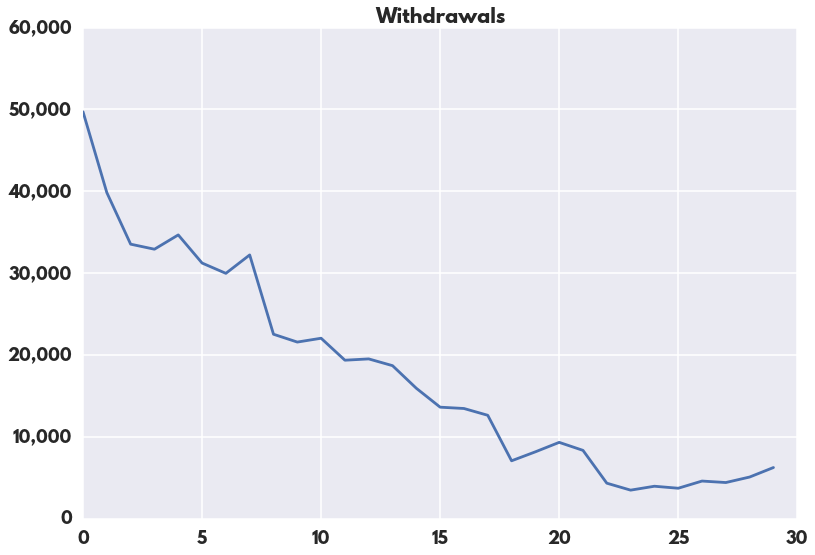

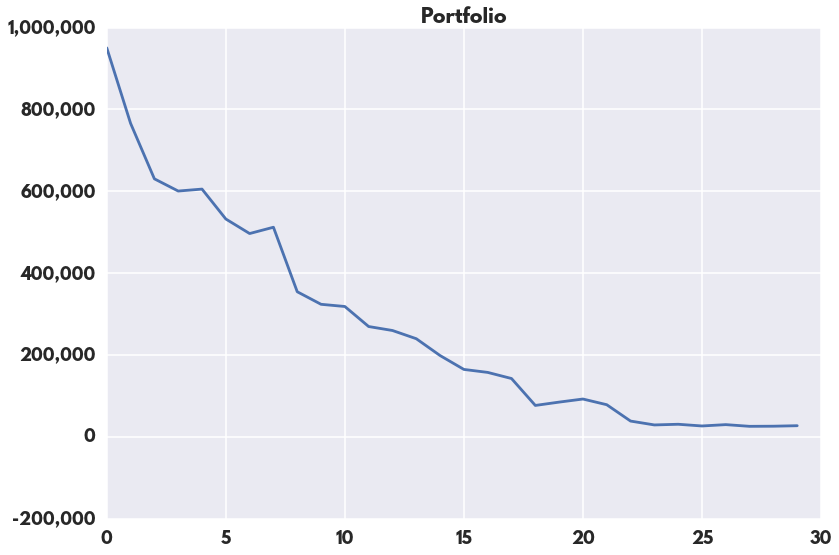

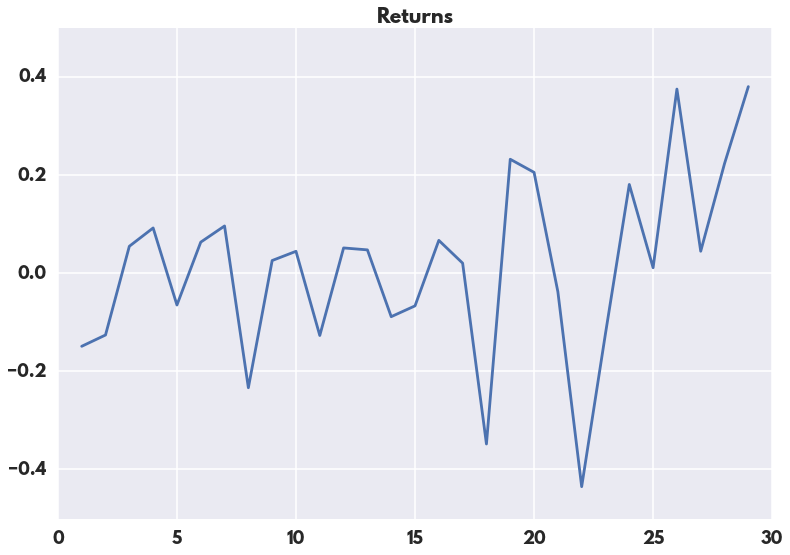

In [38]:
r = simulate.withdrawals(montecarlo.LowYieldsAutoRegression(), years=30, withdraw=withdrawal.VPW,)
plot.plot([n.withdraw_r for n in r], title='Withdrawals')
plot.plot([n.portfolio_r for n in r], title='Portfolio')
plot.plot([n.returns for n in r], title='Returns', add_commas=False, zero_based=False)

In [39]:
pprint(['%.2f' % float(n.returns) for n in r[1:]])

['-0.15',
 '-0.13',
 '0.05',
 '0.09',
 '-0.07',
 '0.06',
 '0.10',
 '-0.23',
 '0.03',
 '0.04',
 '-0.13',
 '0.05',
 '0.05',
 '-0.09',
 '-0.07',
 '0.07',
 '0.02',
 '-0.35',
 '0.23',
 '0.21',
 '-0.04',
 '-0.43',
 '-0.12',
 '0.18',
 '0.01',
 '0.37',
 '0.04',
 '0.22',
 '0.38']


In [3]:
def harness(iters, sim):
    successes = 0
    incomes = pandas.Series(iters)
    for i in range(iters):
        sim_results = sim()
        incomes.loc[i] = float(metrics.cew([(n.withdraw_pct_orig * 100) + Decimal('.01') for n in sim_results]))
        if sim_results[-1].portfolio_n > 0:
            successes += 1
    return (successes/iters, incomes)

def p_q(incomes):
    print('90th percentile income', incomes.quantile(.9))
    print('50th percentile income', incomes.quantile(.5))
    print('10th percentile income', incomes.quantile(.1))
    print('5th percentile income', incomes.quantile(.05))
    print('1st percentile income', incomes.quantile(.01))   

In [4]:
iters = 100
EM = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsAutoRegression(), years=30))
VPW = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsAutoRegression(),
                                                                           harvesting=harvesting.N_60_RebalanceHarvesting,
                                                                           withdraw=withdrawal.VPW,
                                                                           years=30))
ECM = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsAutoRegression(),
                                                                           withdraw=withdrawal.ECM,
                                                                           years=30))

In [5]:
for i in (EM, ECM, VPW):
    print('Success rate', i[0])
    p_q(i[1])
    print()

Success rate 0.86
90th percentile income 5.43010756768
50th percentile income 3.99785479893
10th percentile income 0.0230311154557
5th percentile income 0.016503859149
1st percentile income 0.0149355022681

Success rate 0.92
90th percentile income 5.55653167483
50th percentile income 4.29321682672
10th percentile income 2.7535825484
5th percentile income 0.0156508457963
1st percentile income 0.013150122372

Success rate 1.0
90th percentile income 6.65897347235
50th percentile income 4.47624682016
10th percentile income 2.31299460196
5th percentile income 1.91154510087
1st percentile income 1.4656398053



In [6]:
def run_one(years, stock_pct, a=None):
    bond_pct = (1 - stock_pct)
    
    if not a:
        a = montecarlo.LowYieldsAutoRegression(initial_yield=.025)
    
    returns = []
    
    for i, j in zip(range(years+1), a):
        stocks = float(j.stocks - j.inflation)
        bonds = float(j.bonds - j.inflation)
        total_return = (stocks * stock_pct) + (bonds * bond_pct)
        returns.append(total_return)
    return returns

In [7]:
a = montecarlo.LowYieldsAutoRegression(initial_yield=.025, logging=True)
run_one(30, .6, a=a)
print('inflation', a.log['inflation'].mean())
print('stocks', a.log['stocks'].mean())
print('bonds', a.log['bonds'].mean())
print('-' * 65)
print(a.log)

inflation 0.024441543737653674
stocks 0.09268627660421103
bonds 0.03705052605547782
-----------------------------------------------------------------
      y_prev     y_new        rc    stocks     bonds  inflation
0   0.025000  0.025604  0.002599  0.575098  0.022141   0.051295
1   0.025604  0.020365  0.000000 -0.122049  0.101500  -0.004704
2   0.020365  0.010000  0.000000  0.125686  0.116668   0.014859
3   0.010000  0.032455  0.018537  0.083126 -0.002679   0.010317
4   0.032455  0.017160  0.004421  0.187465  0.051883   0.031930
5   0.017160  0.016399  0.000000 -0.210539 -0.034520  -0.014023
6   0.016399  0.028626  0.000000  0.007959 -0.029240   0.011895
7   0.028626  0.029289  0.003558 -0.132886  0.054243   0.042803
8   0.029289  0.049087  0.014735 -0.101483  0.055583  -0.004902
9   0.049087  0.035871  0.000251  0.235289  0.116026   0.004293
10  0.035871  0.025724  0.011050  0.331498  0.120496   0.036384
11  0.025724  0.037326  0.015060  0.037913 -0.035893   0.013191
12  0.037326  0.03

In [8]:
iters = 100

s = pandas.Series(iters)

for i in range(iters):
    years = 30
    stock_pct = .6
    ssr = metrics.ssr([Decimal(n) for n in run_one(years, stock_pct)])
    s[i] = float(ssr)

In [9]:
s.median()

0.047

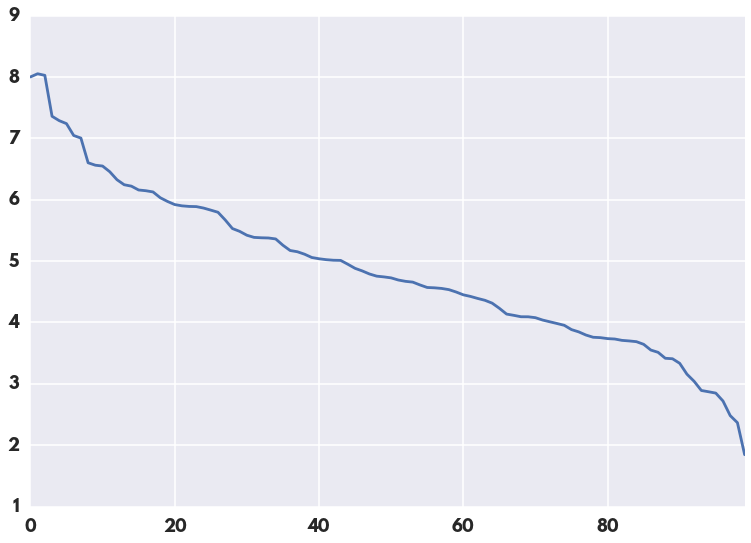

In [10]:
rates = pandas.Series(100)
for i in range(0, 100):
    q = s.quantile((100-i)/100)
    rates[i] = q * 100
rates.plot()